Loading CSV files...
CSV files loaded successfully.

--- Train DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49451 entries, 0 to 49450
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        49451 non-null  object
 1   subject_id                49451 non-null  int64 
 2   hadm_id                   49451 non-null  int64 
 3   dicom_id                  49451 non-null  object
 4   study_id                  49451 non-null  int64 
 5   ViewPosition              49451 non-null  object
 6   image_path                49451 non-null  object
 7   readmitted_within_30days  49451 non-null  bool  
dtypes: bool(1), int64(3), object(4)
memory usage: 2.7+ MB

Shape: (49451, 8)

Head:
                  id  subject_id   hadm_id  \
0  10869829_25238191    10869829  25238191   
1  10869829_25238191    10869829  25238191   
2  10869829_25238191    10869829  25238191   
3

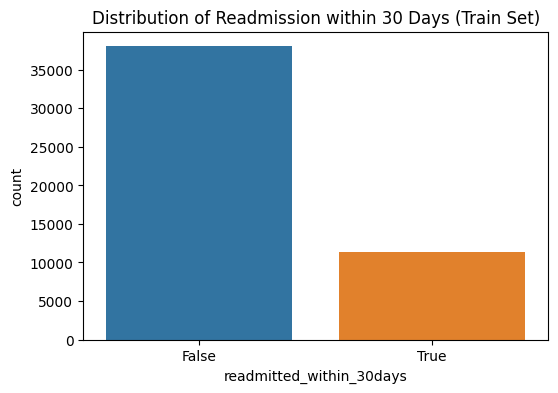


--- Analysis of EHR Sequence Lengths (Days of Stay) ---

Summary Statistics for Sequence Lengths:
count    14532.000000
mean        15.086017
std         17.371530
min          3.000000
25%          7.000000
50%         11.000000
75%         18.000000
max       1193.000000
dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


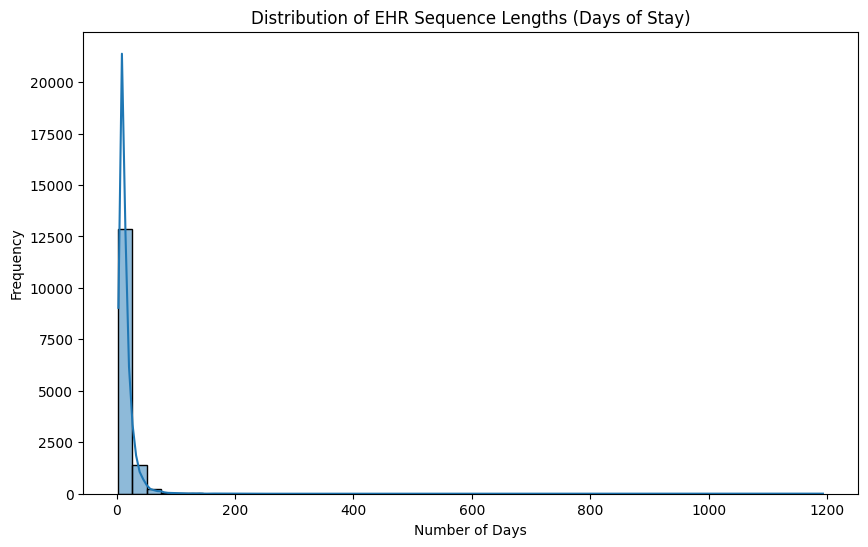

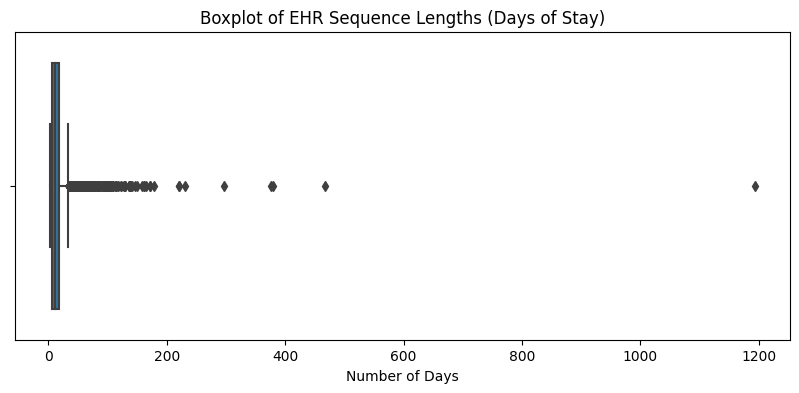


--- Step 1: Data Loading and Initial Exploration Complete ---


In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Adjust this path based on your Kaggle input directory structure
# Example: if your data is in /kaggle/input/your-competition-data/
DATASET_NAME = "dataset"  # Change this to your dataset name
INPUT_DIR = f"/kaggle/input/dataset" # <-- **** CHANGE THIS ****

# File names (assuming they are directly in the INPUT_DIR)
TRAIN_CSV = os.path.join(INPUT_DIR, 'train.csv')
VALID_CSV = os.path.join(INPUT_DIR, 'valid.csv')
TEST_CSV = os.path.join(INPUT_DIR, 'test.csv')
EHR_PICKLE = os.path.join(INPUT_DIR, 'ehr_preprocessed_seq_by_day_cat_embedding.pkl')

# --- 1. Load CSV Files ---

print(f"Loading CSV files...")
try:
    df_train = pd.read_csv(TRAIN_CSV)
    df_valid = pd.read_csv(VALID_CSV)
    df_test = pd.read_csv(TEST_CSV)
    print("CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    print(f"Please ensure the INPUT_DIR '{INPUT_DIR}' is correct and contains the files.")
    # Stop execution if files aren't found
    raise

print("\n--- Train DataFrame Info ---")
df_train.info()
print(f"\nShape: {df_train.shape}")
print("\nHead:")
print(df_train.head())

print("\n--- Validation DataFrame Info ---")
df_valid.info()
print(f"\nShape: {df_valid.shape}")
print("\nHead:")
print(df_valid.head())

print("\n--- Test DataFrame Info ---")
df_test.info()
print(f"\nShape: {df_test.shape}")
print("\nHead:")
print(df_test.head()) # Note: No 'readmitted_within_30days' column

# --- 2. Load EHR Pickle File ---

print(f"\nLoading EHR pickle file: {EHR_PICKLE}...")
try:
    with open(EHR_PICKLE, 'rb') as f:
        ehr_data = pickle.load(f)
    print("EHR pickle file loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading pickle file: {e}")
    print(f"Please ensure the INPUT_DIR '{INPUT_DIR}' is correct and contains the pickle file.")
    # Stop execution if file isn't found
    raise

print("\n--- Exploring EHR Data Structure ---")
print(f"Type of loaded EHR data: {type(ehr_data)}")

# Check the keys if it's a dictionary (as expected)
if isinstance(ehr_data, dict):
    print(f"Keys in the EHR data dictionary: {list(ehr_data.keys())}")

    # Extract the main components
    feat_dict = ehr_data.get('feat_dict')
    feat_cols = ehr_data.get('feat_cols')
    cat_idxs = ehr_data.get('cat_idxs')
    cat_dims = ehr_data.get('cat_dims')
    demo_cols = ehr_data.get('demo_cols')
    icd_cols = ehr_data.get('icd_cols')
    lab_cols = ehr_data.get('lab_cols')
    med_cols = ehr_data.get('med_cols')

    if feat_dict is not None:
        print(f"\nNumber of admissions (keys) in feat_dict: {len(feat_dict)}")
        # Display info about one admission's data
        if len(feat_dict) > 0:
            example_id = list(feat_dict.keys())[0]
            example_sequence = feat_dict[example_id]
            print(f"\nExample EHR sequence for admission id '{example_id}':")
            print(f"  Type: {type(example_sequence)}")
            # Check if it's a list or numpy array to get length and shape
            if isinstance(example_sequence, (list, np.ndarray)):
                 print(f"  Length (days): {len(example_sequence)}")
                 if len(example_sequence) > 0:
                      print(f"  Shape of data for one day: {np.shape(example_sequence[0])}")
            else:
                print(f"  Unexpected data type for sequence: {type(example_sequence)}")

    if feat_cols is not None:
        print(f"\nNumber of feature columns: {len(feat_cols)}")
        # print(f"Feature column names: {feat_cols}") # Uncomment to see all names

    if cat_idxs is not None:
        print(f"\nNumber of categorical features identified: {len(cat_idxs)}")
        # print(f"Indices of categorical features: {cat_idxs}")

    if cat_dims is not None:
        print(f"\nNumber of categorical dimensions provided: {len(cat_dims)}")
        # print(f"Dimensions of categorical features: {cat_dims}")

    if demo_cols is not None:
        print(f"\nDemographic columns: {demo_cols}")
    if icd_cols is not None:
        print(f"\nICD columns: {icd_cols}")
    if lab_cols is not None:
        print(f"\nLab columns: {lab_cols}")
    if med_cols is not None:
        print(f"\nMedication columns: {med_cols}")

else:
    print("Loaded EHR data is not a dictionary as expected. Please inspect its structure.")

# --- 3. Link CSV IDs with EHR Feature Dictionary ---

print("\n--- Checking ID Overlap ---")
if feat_dict is not None:
    train_ids = set(df_train['id'].unique())
    valid_ids = set(df_valid['id'].unique())
    test_ids = set(df_test['id'].unique())
    ehr_ids = set(feat_dict.keys())

    print(f"Number of unique IDs in train.csv: {len(train_ids)}")
    print(f"Number of unique IDs in valid.csv: {len(valid_ids)}")
    print(f"Number of unique IDs in test.csv: {len(test_ids)}")
    print(f"Number of unique IDs in ehr_data['feat_dict']: {len(ehr_ids)}")

    print(f"\nDo all train IDs exist in EHR data? {'Yes' if train_ids.issubset(ehr_ids) else 'No'}")
    print(f"Do all valid IDs exist in EHR data? {'Yes' if valid_ids.issubset(ehr_ids) else 'No'}")
    print(f"Do all test IDs exist in EHR data?  {'Yes' if test_ids.issubset(ehr_ids) else 'No'}")

    # Check for missing IDs
    missing_train_ids = train_ids - ehr_ids
    missing_valid_ids = valid_ids - ehr_ids
    missing_test_ids = test_ids - ehr_ids

    if missing_train_ids:
        print(f"WARNING: {len(missing_train_ids)} train IDs not found in EHR data.")
    if missing_valid_ids:
        print(f"WARNING: {len(missing_valid_ids)} valid IDs not found in EHR data.")
    if missing_test_ids:
        print(f"WARNING: {len(missing_test_ids)} test IDs not found in EHR data.")

# --- 4. Analyze Target Variable Distribution (Train Set) ---

print("\n--- Target Variable Distribution (Train Set) ---")
target_col = 'readmitted_within_30days'
if target_col in df_train.columns:
    print(df_train[target_col].value_counts())
    print("\nProportion:")
    print(df_train[target_col].value_counts(normalize=True))

    # Plotting the distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target_col, data=df_train)
    plt.title('Distribution of Readmission within 30 Days (Train Set)')
    plt.show()
else:
    print(f"Target column '{target_col}' not found in the training data.")

# --- 5. Analyze EHR Sequence Lengths ---

print("\n--- Analysis of EHR Sequence Lengths (Days of Stay) ---")
if feat_dict is not None:
    sequence_lengths = []
    for admission_id, sequence in feat_dict.items():
         if isinstance(sequence, (list, np.ndarray)):
              sequence_lengths.append(len(sequence))
         else:
              print(f"Warning: Unexpected data type for sequence of ID {admission_id}: {type(sequence)}. Skipping length calculation.")


    if sequence_lengths:
        lengths_series = pd.Series(sequence_lengths)
        print("\nSummary Statistics for Sequence Lengths:")
        print(lengths_series.describe())

        # Plotting the distribution of sequence lengths
        plt.figure(figsize=(10, 6))
        sns.histplot(lengths_series, bins=50, kde=True)
        plt.title('Distribution of EHR Sequence Lengths (Days of Stay)')
        plt.xlabel('Number of Days')
        plt.ylabel('Frequency')
        plt.show()

        # Boxplot for a different view
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=lengths_series)
        plt.title('Boxplot of EHR Sequence Lengths (Days of Stay)')
        plt.xlabel('Number of Days')
        plt.show()
    else:
        print("Could not calculate sequence lengths.")

else:
    print("feat_dict not loaded correctly, cannot analyze sequence lengths.")

print("\n--- Step 1: Data Loading and Initial Exploration Complete ---")

Creating admission-level training data...
Shape of aggregated train data: (8234, 1)
Head of aggregated train data:
                   readmitted_within_30days
id                                         
10869829_25238191                     False
12347278_29852086                     False
11157850_29572307                      True
11958726_24320913                     False
11944377_26689168                     False

--- Target Variable Distribution (Admission Level - Train Set) ---
Counts (per admission):
readmitted_within_30days
False    6785
True     1449
Name: count, dtype: int64

Proportions (per admission):
readmitted_within_30days
False    0.824022
True     0.175978
Name: proportion, dtype: float64

Plotting admission-level target distribution...


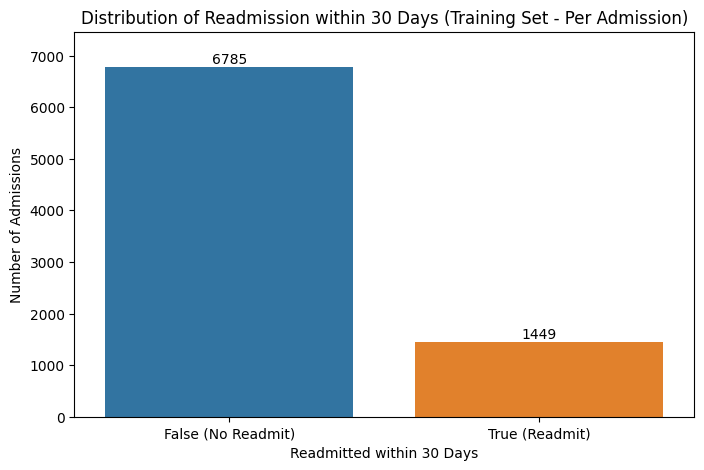


Creating admission-level validation data...
Shape of aggregated validation data: (2788, 1)
Head of aggregated validation data:
                   readmitted_within_30days
id                                         
17910612_22301530                      True
11933892_24379230                     False
12489693_25551183                     False
17716301_21544901                     False
11312196_20569926                     False

Creating admission-level test data...
Shape of aggregated test data: (2741, 0)
Head of aggregated test data:
Empty DataFrame
Columns: []
Index: [16026764_21404901, 18463717_24608289, 16914073_28403863, 17119335_28722930, 10599715_20082646]

Step 2a: Data Aggregation Complete. You now have train_agg_df, valid_agg_df, and test_agg_df.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create Admission-Level Training DataFrame ---
print("Creating admission-level training data...")
# Keep only necessary columns and drop duplicates based on 'id'
# Assumption: 'readmitted_within_30days' is consistent for all rows with the same 'id'
train_agg_df = df_train[['id', 'readmitted_within_30days']].drop_duplicates(subset='id')
# Set 'id' as the index for easy lookup later
train_agg_df = train_agg_df.set_index('id')
print(f"Shape of aggregated train data: {train_agg_df.shape}")
print("Head of aggregated train data:")
print(train_agg_df.head())

# --- Recalculate Target Distribution on Aggregated Training Data ---
print("\n--- Target Variable Distribution (Admission Level - Train Set) ---")
target_counts_agg = train_agg_df['readmitted_within_30days'].value_counts()
target_proportions_agg = train_agg_df['readmitted_within_30days'].value_counts(normalize=True)

print("Counts (per admission):")
print(target_counts_agg)
print("\nProportions (per admission):")
print(target_proportions_agg)

# Plotting the corrected distribution
print("\nPlotting admission-level target distribution...")
plt.figure(figsize=(8, 5))
# Need to reset index temporarily for seaborn countplot if 'id' is the index
sns.countplot(x='readmitted_within_30days', data=train_agg_df.reset_index(), order=[False, True]) # Specify order
plt.title('Distribution of Readmission within 30 Days (Training Set - Per Admission)')
plt.xlabel('Readmitted within 30 Days')
plt.ylabel('Number of Admissions')
# Add text labels for counts
# Get counts for False then True explicitly
count_false = target_counts_agg.get(False, 0)
count_true = target_counts_agg.get(True, 0)
plt.text(0, count_false + max(count_false, count_true)*0.01, str(count_false), ha='center') # Adjust offset dynamically
plt.text(1, count_true + max(count_false, count_true)*0.01, str(count_true), ha='center') # Adjust offset dynamically
plt.xticks([0, 1], ['False (No Readmit)', 'True (Readmit)']) # Set clear tick labels
plt.ylim(0, max(count_false, count_true) * 1.1) # Adjust y-limit for text visibility
plt.show()

# --- Create Admission-Level Validation DataFrame ---
print("\nCreating admission-level validation data...")
valid_agg_df = df_valid[['id', 'readmitted_within_30days']].drop_duplicates(subset='id').set_index('id')
print(f"Shape of aggregated validation data: {valid_agg_df.shape}")
print("Head of aggregated validation data:")
print(valid_agg_df.head())
# You can optionally check target distribution for validation set too
# print("\nValidation set target distribution:")
# print(valid_agg_df['readmitted_within_30days'].value_counts(normalize=True))


# --- Create Admission-Level Test DataFrame ---
print("\nCreating admission-level test data...")
test_agg_df = df_test[['id']].drop_duplicates(subset='id').set_index('id')
print(f"Shape of aggregated test data: {test_agg_df.shape}")
print("Head of aggregated test data:")
print(test_agg_df.head())

print("\nStep 2a: Data Aggregation Complete. You now have train_agg_df, valid_agg_df, and test_agg_df.")

In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm # Optional: for progress bar

# Assume feat_dict, train_agg_df, valid_agg_df, test_agg_df are loaded

# --- Configuration ---
MAX_SEQ_LENGTH = 60 # Cap sequence length (use last N days)

# --- Define Aggregation Functions ---
# Add more functions if needed (e.g., median, specific quantiles)
AGG_FUNCS = ['mean', 'std', 'max', 'min', 'last']

# --- Helper Function to Aggregate One Sequence ---
def aggregate_sequence(sequence, max_len):
    """
    Aggregates a single patient's time-series sequence.
    Handles capping and calculates statistics.
    """
    if not isinstance(sequence, np.ndarray) or sequence.ndim != 2:
        # Handle cases where data might be missing or malformed for an ID
        # Return a vector of NaNs matching the expected output shape
        num_features = 171 # Assuming 171 base features
        num_agg_funcs = len(AGG_FUNCS)
        return [np.nan] * (num_features * num_agg_funcs)

    # Cap the sequence length (take the last max_len days)
    if len(sequence) > max_len:
        sequence = sequence[-max_len:]

    aggregated_features = []
    num_features = sequence.shape[1] # Should be 171

    for func_name in AGG_FUNCS:
        if func_name == 'mean':
            agg_vals = np.nanmean(sequence, axis=0)
        elif func_name == 'std':
            agg_vals = np.nanstd(sequence, axis=0)
        elif func_name == 'max':
            agg_vals = np.nanmax(sequence, axis=0)
        elif func_name == 'min':
            agg_vals = np.nanmin(sequence, axis=0)
        elif func_name == 'last':
            agg_vals = sequence[-1, :] # Get the last day's features
        else:
            # Fallback for undefined functions - can be extended
            agg_vals = np.full(num_features, np.nan)

        # Handle potential all-NaN slices resulting in NaN after aggregation
        # Replace NaNs resulting from calculation if needed, e.g., std of single day is NaN
        # A simple approach is to fill NaNs resulting from aggregation with 0 or a specific value,
        # but this depends on the feature and model. We'll keep NaNs for now.
        # agg_vals = np.nan_to_num(agg_vals, nan=0.0) # Example: replace NaN with 0

        aggregated_features.extend(agg_vals.tolist()) # Flatten list

    return aggregated_features

# --- Create Feature Names ---
# Assumes 'feat_cols' is loaded from the pickle file
base_feature_names = ehr_data.get('feature_cols', [f'feat_{i}' for i in range(171)]) # Use loaded names or defaults
feature_names = [f'{col}_{func}' for func in AGG_FUNCS for col in base_feature_names]
print(f"Total number of aggregated features per admission: {len(feature_names)}") # Should be 171 * len(AGG_FUNCS)

# --- Process Train Data ---
print(f"\nAggregating training data (using last {MAX_SEQ_LENGTH} days)...")
train_features_list = []
for admission_id in tqdm(train_agg_df.index):
    sequence = feat_dict.get(admission_id, None) # Get sequence safely
    if sequence is not None:
        aggregated = aggregate_sequence(sequence, MAX_SEQ_LENGTH)
        train_features_list.append(aggregated)
    else:
        print(f"Warning: No sequence found for training ID {admission_id}")
        # Append NaNs if ID is missing in feat_dict
        num_features = 171
        num_agg_funcs = len(AGG_FUNCS)
        train_features_list.append([np.nan] * (num_features * num_agg_funcs))


X_train = pd.DataFrame(train_features_list, index=train_agg_df.index, columns=feature_names)
y_train = train_agg_df['readmitted_within_30days']

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print("Example aggregated features for training set:")
print(X_train.head())
# Check for NaNs introduced during aggregation
print(f"\nPercentage of NaN values in X_train: {X_train.isna().sum().sum() / X_train.size * 100:.2f}%")


# --- Process Validation Data ---
print(f"\nAggregating validation data (using last {MAX_SEQ_LENGTH} days)...")
valid_features_list = []
for admission_id in tqdm(valid_agg_df.index):
    sequence = feat_dict.get(admission_id, None)
    if sequence is not None:
        aggregated = aggregate_sequence(sequence, MAX_SEQ_LENGTH)
        valid_features_list.append(aggregated)
    else:
        print(f"Warning: No sequence found for validation ID {admission_id}")
        num_features = 171
        num_agg_funcs = len(AGG_FUNCS)
        valid_features_list.append([np.nan] * (num_features * num_agg_funcs))


X_valid = pd.DataFrame(valid_features_list, index=valid_agg_df.index, columns=feature_names)
y_valid = valid_agg_df['readmitted_within_30days']

print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of y_valid: {y_valid.shape}")
print(f"Percentage of NaN values in X_valid: {X_valid.isna().sum().sum() / X_valid.size * 100:.2f}%")


# --- Process Test Data ---
print(f"\nAggregating test data (using last {MAX_SEQ_LENGTH} days)...")
test_features_list = []
for admission_id in tqdm(test_agg_df.index):
    sequence = feat_dict.get(admission_id, None)
    if sequence is not None:
        aggregated = aggregate_sequence(sequence, MAX_SEQ_LENGTH)
        test_features_list.append(aggregated)
    else:
        print(f"Warning: No sequence found for test ID {admission_id}")
        num_features = 171
        num_agg_funcs = len(AGG_FUNCS)
        test_features_list.append([np.nan] * (num_features * num_agg_funcs))


X_test = pd.DataFrame(test_features_list, index=test_agg_df.index, columns=feature_names)

print(f"Shape of X_test: {X_test.shape}")
print(f"Percentage of NaN values in X_test: {X_test.isna().sum().sum() / X_test.size * 100:.2f}%")


print("\nStep 2b: Feature Aggregation Complete.")
print("You now have X_train, y_train, X_valid, y_valid, X_test.")

Total number of aggregated features per admission: 855

Aggregating training data (using last 60 days)...


  0%|          | 0/8234 [00:00<?, ?it/s]

Shape of X_train: (8234, 855)
Shape of y_train: (8234,)
Example aggregated features for training set:
                   age_mean  gender_mean  ethnicity_mean  Y90-Y99_mean  \
id                                                                       
10869829_25238191      52.0          1.0             6.0           0.0   
12347278_29852086      62.0          1.0             6.0           0.0   
11157850_29572307      51.0          1.0             5.0           0.0   
11958726_24320913      75.0          0.0             5.0           0.0   
11944377_26689168      45.0          1.0             5.0           0.0   

                   G30-G32_mean  O85-O92_mean  C60-C63_mean  F40-F48_mean  \
id                                                                          
10869829_25238191           0.0           0.0           0.0           0.0   
12347278_29852086           0.0           0.0           0.0           0.0   
11157850_29572307           0.0           0.0           0.0           0

  0%|          | 0/2788 [00:00<?, ?it/s]

Shape of X_valid: (2788, 855)
Shape of y_valid: (2788,)
Percentage of NaN values in X_valid: 0.00%

Aggregating test data (using last 60 days)...


  0%|          | 0/2741 [00:00<?, ?it/s]

Shape of X_test: (2741, 855)
Percentage of NaN values in X_test: 0.00%

Step 2b: Feature Aggregation Complete.
You now have X_train, y_train, X_valid, y_valid, X_test.


Scaling features using StandardScaler...
Scaling complete.
Shape of X_train_scaled: (8234, 855)
Shape of X_valid_scaled: (2788, 855)
Shape of X_test_scaled: (2741, 855)

Training Logistic Regression model...
Training complete.

Evaluating model on validation set...

Validation Set Metrics:
AUC-ROC: 0.7537
AUC-PR (Average Precision): 0.5200

Classification Report (Validation Set):
                    precision    recall  f1-score   support

No Readmit (False)       0.90      0.79      0.84      2307
    Readmit (True)       0.36      0.58      0.45       481

          accuracy                           0.75      2788
         macro avg       0.63      0.69      0.64      2788
      weighted avg       0.81      0.75      0.77      2788


Confusion Matrix (Validation Set):


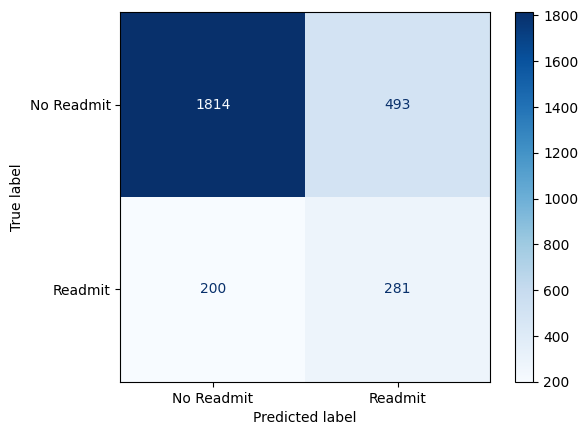


Step 3: Baseline Model Training and Evaluation Complete.


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assume X_train, y_train, X_valid, y_valid, X_test exist from previous step

# --- 1. Feature Scaling ---
print("Scaling features using StandardScaler...")
scaler = StandardScaler()

# Fit scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data using the SAME fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_valid_scaled: {X_valid_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")


# --- 2. Train Baseline Model (Logistic Regression) ---
print("\nTraining Logistic Regression model...")

# Initialize model - use class_weight='balanced' for imbalance
# Increase max_iter if it fails to converge, add penalty/C for regularization if needed
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000, solver='liblinear')

# Train the model
log_reg_model.fit(X_train_scaled, y_train)

print("Training complete.")


# --- 3. Evaluate on Validation Set ---
print("\nEvaluating model on validation set...")

# Predict probabilities (needed for AUC-ROC, AUC-PR and submission)
# predict_proba returns probabilities for [class_0, class_1]
y_valid_pred_proba = log_reg_model.predict_proba(X_valid_scaled)[:, 1] # Probability of positive class (True)

# Predict class labels (optional, for classification report)
y_valid_pred_labels = log_reg_model.predict(X_valid_scaled)

# Calculate Metrics
roc_auc = roc_auc_score(y_valid, y_valid_pred_proba)
avg_precision = average_precision_score(y_valid, y_valid_pred_proba) # AUC-PR

print(f"\nValidation Set Metrics:")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR (Average Precision): {avg_precision:.4f}")

# Classification Report (uses predicted labels, threshold is 0.5 by default)
print("\nClassification Report (Validation Set):")
# Note: target_names map False->0, True->1
print(classification_report(y_valid, y_valid_pred_labels, target_names=['No Readmit (False)', 'Readmit (True)']))

# Confusion Matrix
print("\nConfusion Matrix (Validation Set):")
cm = confusion_matrix(y_valid, y_valid_pred_labels, labels=log_reg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Readmit', 'Readmit'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("\nStep 3: Baseline Model Training and Evaluation Complete.")

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assume X_train, y_train, X_valid, y_valid, X_test, scaler exist from previous steps
# Assume X_train_scaled, X_valid_scaled, X_test_scaled also exist

# --- 1. Identify and Remove Zero-Variance Features ---
print("Identifying and removing zero-variance features...")

# Calculate variance on the scaled training data
variances = np.var(X_train_scaled, axis=0)
zero_variance_indices = np.where(variances == 0)[0]
non_zero_variance_indices = np.where(variances != 0)[0]

print(f"Number of features before filtering: {X_train_scaled.shape[1]}")
print(f"Number of zero-variance features found: {len(zero_variance_indices)}")
print(f"Number of features after filtering: {len(non_zero_variance_indices)}")

# Filter the feature matrices
X_train_filt = X_train_scaled[:, non_zero_variance_indices]
X_valid_filt = X_valid_scaled[:, non_zero_variance_indices]
X_test_filt = X_test_scaled[:, non_zero_variance_indices]

print(f"\nNew shape of X_train_filt: {X_train_filt.shape}")
print(f"New shape of X_valid_filt: {X_valid_filt.shape}")
print(f"New shape of X_test_filt: {X_test_filt.shape}")


# --- 2. Re-train LightGBM Model with Filtered Data ---
print("\nRe-training LightGBM model with filtered features...")

# Calculate scale_pos_weight (same as before)
neg_count = np.sum(y_train == False)
pos_count = np.sum(y_train == True)
scale_pos_weight_value = neg_count / pos_count
print(f"Using scale_pos_weight: {scale_pos_weight_value:.2f}")

# Initialize LGBMClassifier (same parameters as before)
lgbm_model_filt = lgb.LGBMClassifier(
    objective='binary',
    metric='aucpr',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
)

# Train with early stopping using filtered validation data
print("Training with early stopping...")
try:
    lgbm_model_filt.fit(
        X_train_filt,
        y_train,
        eval_set=[(X_valid_filt, y_valid)],
        eval_metric='aucpr',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=10)]
    )
    print("\nTraining complete.")

    # --- 3. Evaluate on Filtered Validation Set ---
    print("\nEvaluating filtered LightGBM model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_lgbm_filt = lgbm_model_filt.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_lgbm_filt = lgbm_model_filt.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_lgbm_filt = roc_auc_score(y_valid, y_valid_pred_proba_lgbm_filt)
    avg_precision_lgbm_filt = average_precision_score(y_valid, y_valid_pred_proba_lgbm_filt) # AUC-PR

    print(f"\nValidation Set Metrics (Filtered LightGBM):")
    print(f"AUC-ROC: {roc_auc_lgbm_filt:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_lgbm_filt:.4f}")
    if lgbm_model_filt.best_iteration_:
        print(f"Best iteration found by early stopping: {lgbm_model_filt.best_iteration_}")


    # Classification Report
    print("\nClassification Report (Validation Set - Filtered LightGBM):")
    print(classification_report(y_valid, y_valid_pred_labels_lgbm_filt, target_names=['No Readmit (False)', 'Readmit (True)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - Filtered LightGBM):")
    cm_lgbm_filt = confusion_matrix(y_valid, y_valid_pred_labels_lgbm_filt, labels=lgbm_model_filt.classes_)
    disp_lgbm_filt = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm_filt, display_labels=['No Readmit', 'Readmit'])
    disp_lgbm_filt.plot(cmap=plt.cm.Blues)
    plt.show()

    print("\nStep 3b (Retry): Filtered LightGBM Model Training and Evaluation Complete.")

except Exception as e:
    print(f"\nAn error occurred during the filtered LGBM training/evaluation: {e}")
    print("Consider further debugging if the error persists.")

Identifying and removing zero-variance features...
Number of features before filtering: 855
Number of zero-variance features found: 204
Number of features after filtering: 651

New shape of X_train_filt: (8234, 651)
New shape of X_valid_filt: (2788, 651)
New shape of X_test_filt: (2741, 651)

Re-training LightGBM model with filtered features...
Using scale_pos_weight: 4.68
Training with early stopping...
[LightGBM] [Info] Number of positive: 1449, number of negative: 6785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12788
[LightGBM] [Info] Number of data points in the train set: 8234, number of used features: 368
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175978 -> initscore=-1.543841
[LightGBM] [Info] Start training from score -1.543841

An error occurred during the filte

Initializing LightGBM model (fixed estimators, no early stopping)...
Using scale_pos_weight: 4.68

Training LightGBM model for fixed 200 iterations...
[LightGBM] [Info] Number of positive: 1449, number of negative: 6785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12788
[LightGBM] [Info] Number of data points in the train set: 8234, number of used features: 368
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175978 -> initscore=-1.543841
[LightGBM] [Info] Start training from score -1.543841

Training complete.

Evaluating fixed-iteration LightGBM model on validation set...

Validation Set Metrics (Fixed 200 Iterations LightGBM):
AUC-ROC: 0.7687
AUC-PR (Average Precision): 0.5927

Classification Report (Validation Set - Fixed LightGBM):
                    precision    recall  f

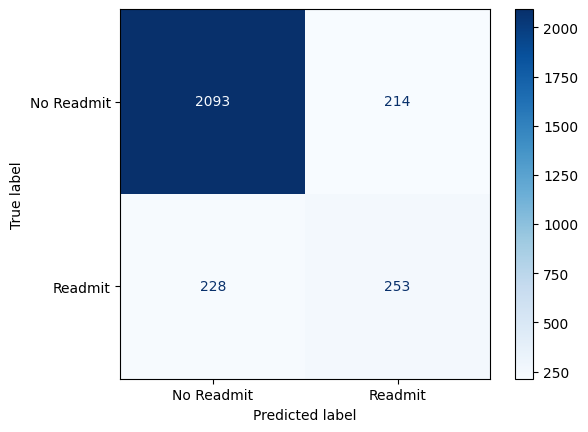


Step 3b (Retry 4 - No Early Stopping): Fixed LightGBM Model Training and Evaluation Complete.


In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assume X_train_filt, y_train, X_valid_filt, y_valid exist from previous step

# --- 1. Initialize LightGBM Model (Set n_estimators for fixed training) ---
print("Initializing LightGBM model (fixed estimators, no early stopping)...")
# Calculate scale_pos_weight (same as before)
neg_count = np.sum(y_train == False)
pos_count = np.sum(y_train == True)
scale_pos_weight_value = neg_count / pos_count
print(f"Using scale_pos_weight: {scale_pos_weight_value:.2f}")

# Initialize with a fixed number of estimators, metric is less critical now but doesn't hurt
lgbm_model_fixed = lgb.LGBMClassifier(
    objective='binary',
    metric='aucpr',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    n_estimators=200, # Train for a fixed 200 rounds
    learning_rate=0.05,
    num_leaves=31,
)


# --- 2. Train LightGBM Model without Early Stopping ---
print("\nTraining LightGBM model for fixed 200 iterations...")

try:
    # *** Corrected Line: Removed eval_set, eval_metric, and callbacks ***
    lgbm_model_fixed.fit(
        X_train_filt,
        y_train
        # No eval_set or callbacks
    )
    print("\nTraining complete.")

    # --- 3. Evaluate on Filtered Validation Set ---
    # Evaluation proceeds as normal using the trained model
    print("\nEvaluating fixed-iteration LightGBM model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_lgbm_fixed = lgbm_model_fixed.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_lgbm_fixed = lgbm_model_fixed.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_lgbm_fixed = roc_auc_score(y_valid, y_valid_pred_proba_lgbm_fixed)
    avg_precision_lgbm_fixed = average_precision_score(y_valid, y_valid_pred_proba_lgbm_fixed) # AUC-PR

    print(f"\nValidation Set Metrics (Fixed 200 Iterations LightGBM):")
    print(f"AUC-ROC: {roc_auc_lgbm_fixed:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_lgbm_fixed:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - Fixed LightGBM):")
    print(classification_report(y_valid, y_valid_pred_labels_lgbm_fixed, target_names=['No Readmit (False)', 'Readmit (True)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - Fixed LightGBM):")
    cm_lgbm_fixed = confusion_matrix(y_valid, y_valid_pred_labels_lgbm_fixed, labels=lgbm_model_fixed.classes_)
    disp_lgbm_fixed = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm_fixed, display_labels=['No Readmit', 'Readmit'])
    disp_lgbm_fixed.plot(cmap=plt.cm.Blues)
    plt.show()

    print("\nStep 3b (Retry 4 - No Early Stopping): Fixed LightGBM Model Training and Evaluation Complete.")

except Exception as e:
    print(f"\nAn error occurred even without early stopping: {e}")
    # If it fails here, the problem is more fundamental
    print("Debug Info:")
    print(f"X_train_filt type: {type(X_train_filt)}, shape: {X_train_filt.shape}, dtype: {X_train_filt.dtype}")
    print(f"y_train type: {type(y_train)}, shape: {y_train.shape}, dtype: {y_train.dtype}")

In [7]:
# Assuming lgbm_model_fixed is your trained model and feature_names_filt are the names of the 651 features
# First, get the names of the filtered features
feature_names_filt = X_train.columns[non_zero_variance_indices] # Get column names corresponding to filtered indices

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names_filt,
    'importance': lgbm_model_fixed.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop 20 Most Important Features (LightGBM):")
print(feature_importance_df.head(20))

# Optional: Plot feature importances
# plt.figure(figsize=(10, 8))
# sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
# plt.title('Top 20 Feature Importances (LightGBM)')
# plt.tight_layout()
# plt.show()


Top 20 Most Important Features (LightGBM):
                       feature  importance
0                     age_mean         299
110  Platelet Count Blood_mean         177
90         Chloride Blood_mean         172
126            ANALGESICS_mean         162
182          Glucose Blood_std         133
107         Glucose Blood_mean         133
105     Bicarbonate Blood_mean         133
136     ELECT/CALORIC/H2O_mean         131
168   Calcium, Total Blood_std         128
164       Hemoglobin Blood_std         128
83              pO2 Blood_mean         121
121             DIURETICS_mean         120
156       Creatinine Blood_std         119
185   Platelet Count Blood_std         115
86          Lactate Blood_mean         113
123        ANTICOAGULANTS_mean         106
150    ANTIHYPERGLYCEMICS_mean         101
93   Calcium, Total Blood_mean         100
173       Hematocrit Blood_std          99
149           ANTIBIOTICS_mean          99


In [8]:
print("\nGenerating predictions on the test set...")
# Use the final chosen model (here, lgbm_model_fixed as an example)
# Ensure X_test_filt is the scaled and filtered test data
test_pred_proba = lgbm_model_fixed.predict_proba(X_test_filt)[:, 1]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_agg_df.index, # Get IDs from the index of the aggregated test df
    'readmitted_within_30days': test_pred_proba
})

print("Example Submission DataFrame:")
print(submission_df.head())

# Save to CSV
submission_filename = 'my_lgbm_submission.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"\nSubmission file saved as: {submission_filename}")


Generating predictions on the test set...
Example Submission DataFrame:
                  id  readmitted_within_30days
0  16026764_21404901                  0.452091
1  18463717_24608289                  0.887694
2  16914073_28403863                  0.510080
3  17119335_28722930                  0.167172
4  10599715_20082646                  0.123263

Submission file saved as: my_lgbm_submission.csv


Initializing XGBoost model...

Training XGBoost model with early stopping...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.44945
[10]	validation_0-aucpr:0.52692
[20]	validation_0-aucpr:0.54742
[30]	validation_0-aucpr:0.56444
[40]	validation_0-aucpr:0.57239
[50]	validation_0-aucpr:0.57856
[60]	validation_0-aucpr:0.58262
[70]	validation_0-aucpr:0.58671
[80]	validation_0-aucpr:0.58849
[90]	validation_0-aucpr:0.58771
[100]	validation_0-aucpr:0.58763
[110]	validation_0-aucpr:0.58678
[120]	validation_0-aucpr:0.58745
[130]	validation_0-aucpr:0.58674
[136]	validation_0-aucpr:0.58589

Training complete.

Evaluating XGBoost model on validation set...

Validation Set Metrics (XGBoost):
AUC-ROC: 0.7793
AUC-PR (Average Precision): 0.5890

Classification Report (Validation Set - XGBoost):
                precision    recall  f1-score   support

No Readmit (0)       0.90      0.87      0.89      2307
   Readmit (1)       0.48      0.56      0.52       481

      accuracy                           0.82      2788
     macro avg       0.69      0.72      0.70      2788
  weighted avg       0.83     

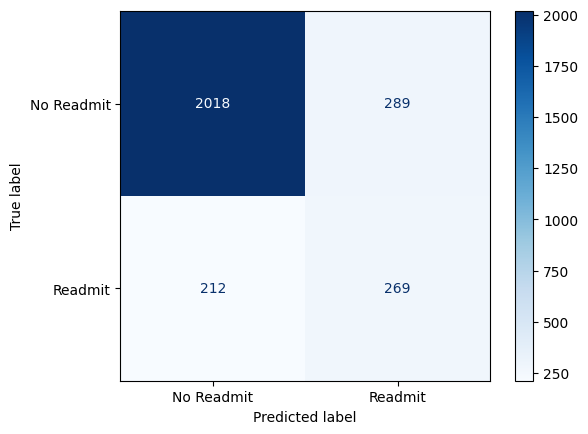


Step 3c: XGBoost Model Training and Evaluation Complete.


In [9]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Ensure pandas is imported if not already

# Assume X_train_filt, y_train, X_valid_filt, y_valid exist from previous steps
# Assume scale_pos_weight_value is calculated (approx 4.68)

# --- 1. Initialize XGBoost Model ---
print("Initializing XGBoost model...")

# Initialize XGBClassifier
# Note: XGBoost typically expects integer labels {0, 1}, but often handles boolean correctly.
# We might need to convert y_train, y_valid to int if it causes issues.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # Output logistic probabilities
    eval_metric='aucpr',         # Monitor AUC-PR for early stopping
    scale_pos_weight=scale_pos_weight_value, # Handle imbalance
    random_state=42,
    n_estimators=1000,           # Set high, use early stopping
    learning_rate=0.05,          # Typical learning rate
    use_label_encoder=False,     # Suppress warning/deprecation
    # Other parameters like max_depth, subsample, colsample_bytree can be tuned later
    # max_depth=6,               # Example: Default is 6
)

# --- 2. Train XGBoost Model with Early Stopping ---
print("\nTraining XGBoost model with early stopping...")

# Convert boolean target to int {0, 1} if needed (good practice for XGBoost)
y_train_int = y_train.astype(int)
y_valid_int = y_valid.astype(int)

try:
    xgb_model.fit(
        X_train_filt,
        y_train_int, # Use integer labels
        eval_set=[(X_valid_filt, y_valid_int)], # Use integer labels for eval set too
        early_stopping_rounds=50, # Stop after 50 rounds of no improvement in aucpr
        verbose=10 # Print evaluation results every 10 rounds
        # Note: eval_metric is handled by the parameter in the constructor
    )
    print("\nTraining complete.")

    # --- 3. Evaluate on Validation Set ---
    print("\nEvaluating XGBoost model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_xgb = xgb_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    # Use the integer labels for comparison
    y_valid_pred_labels_xgb = xgb_model.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_xgb = roc_auc_score(y_valid_int, y_valid_pred_proba_xgb)
    avg_precision_xgb = average_precision_score(y_valid_int, y_valid_pred_proba_xgb) # AUC-PR

    print(f"\nValidation Set Metrics (XGBoost):")
    print(f"AUC-ROC: {roc_auc_xgb:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_xgb:.4f}")
    # XGBoost stores best iteration differently if early stopping is used in fit
    # print(f"Best iteration found by early stopping: {xgb_model.best_iteration}") # May need adjustment based on XGB version


    # Classification Report
    print("\nClassification Report (Validation Set - XGBoost):")
    # Use integer labels {0, 1} for report
    print(classification_report(y_valid_int, y_valid_pred_labels_xgb, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - XGBoost):")
    cm_xgb = confusion_matrix(y_valid_int, y_valid_pred_labels_xgb, labels=[0, 1])
    disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No Readmit', 'Readmit'])
    disp_xgb.plot(cmap=plt.cm.Blues)
    plt.show()

    print("\nStep 3c: XGBoost Model Training and Evaluation Complete.")

except Exception as e:
    print(f"\nAn error occurred during the XGBoost training/evaluation: {e}")
    # You might add debug info here as before if needed

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb # Ensure xgboost is imported if needed

# Assume xgb_model is the trained XGBoost model from the previous successful run
# Assume X_test_filt is the scaled and filtered test data
# Assume test_agg_df holds the aggregated test IDs in its index

print("--- Generating Predictions for Submission (XGBoost Untuned Model) ---")

try:
    # Predict probabilities on the test set
    # Ensure the model variable name matches the one you used (e.g., xgb_model)
    test_pred_proba_xgb = xgb_model.predict_proba(X_test_filt)[:, 1]

    # Create the submission DataFrame
    submission_df_xgb_untuned = pd.DataFrame({
        'id': test_agg_df.index, # Get IDs from the index
        'readmitted_within_30days': test_pred_proba_xgb
    })

    print("\nExample Submission DataFrame:")
    print(submission_df_xgb_untuned.head())

    # Define filename and save to CSV
    submission_filename_xgb = 'xgb_untuned_submission.csv'
    submission_df_xgb_untuned.to_csv(submission_filename_xgb, index=False)

    print(f"\nSubmission file saved as: {submission_filename_xgb}")
    print("You can now download this file from your Kaggle output directory and submit it.")

except NameError as e:
    print(f"Error: A required variable (like xgb_model, X_test_filt, or test_agg_df) was not found.")
    print(f"Please ensure the previous steps defining these variables were run successfully. Specific error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Generating Predictions for Submission (XGBoost Untuned Model) ---

Example Submission DataFrame:
                  id  readmitted_within_30days
0  16026764_21404901                  0.378806
1  18463717_24608289                  0.932639
2  16914073_28403863                  0.610693
3  17119335_28722930                  0.284859
4  10599715_20082646                  0.222368

Submission file saved as: xgb_untuned_submission.csv
You can now download this file from your Kaggle output directory and submit it.


Initializing Random Forest model...

Training Random Forest model...

Training complete.

Evaluating Random Forest model on validation set...

Validation Set Metrics (Random Forest):
AUC-ROC: 0.7886
AUC-PR (Average Precision): 0.5856

Classification Report (Validation Set - Random Forest):
                precision    recall  f1-score   support

No Readmit (0)       0.86      1.00      0.92      2307
   Readmit (1)       0.94      0.20      0.33       481

      accuracy                           0.86      2788
     macro avg       0.90      0.60      0.62      2788
  weighted avg       0.87      0.86      0.82      2788


Confusion Matrix (Validation Set - Random Forest):


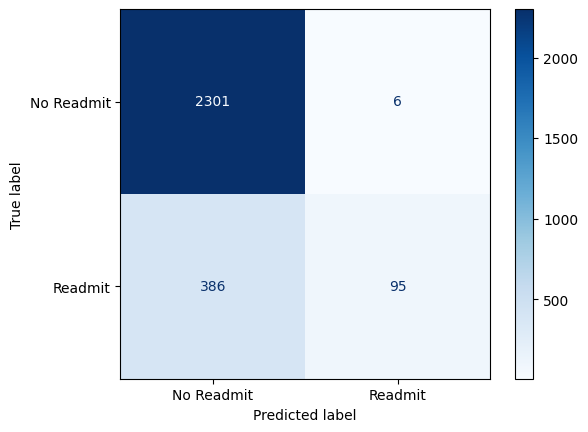


Step 3d: Random Forest Model Training and Evaluation Complete.


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist from previous steps

# --- 1. Initialize Random Forest Model ---
print("Initializing Random Forest model...")

# Initialize RandomForestClassifier
# Use class_weight='balanced' or 'balanced_subsample' for imbalance
# n_jobs=-1 uses all available CPU cores for faster training
rf_model = RandomForestClassifier(
    n_estimators=200,           # Number of trees (can be tuned)
    class_weight='balanced_subsample', # Handles imbalance, balanced_subsample is often good
    random_state=42,
    n_jobs=-1,                  # Use all available cores
    max_depth=None,             # Default: expand nodes until pure or min_samples_split
    min_samples_split=2,        # Default
    min_samples_leaf=1,         # Default
    # Consider tuning max_features, max_depth, min_samples_split, min_samples_leaf later
)

# --- 2. Train Random Forest Model ---
print("\nTraining Random Forest model...")

try:
    rf_model.fit(X_train_filt, y_train_int) # Use integer labels
    print("\nTraining complete.")

    # --- 3. Evaluate on Validation Set ---
    print("\nEvaluating Random Forest model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_rf = rf_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_rf = rf_model.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_rf = roc_auc_score(y_valid_int, y_valid_pred_proba_rf)
    avg_precision_rf = average_precision_score(y_valid_int, y_valid_pred_proba_rf) # AUC-PR

    print(f"\nValidation Set Metrics (Random Forest):")
    print(f"AUC-ROC: {roc_auc_rf:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_rf:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - Random Forest):")
    print(classification_report(y_valid_int, y_valid_pred_labels_rf, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - Random Forest):")
    cm_rf = confusion_matrix(y_valid_int, y_valid_pred_labels_rf, labels=[0, 1])
    disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Readmit', 'Readmit'])
    disp_rf.plot(cmap=plt.cm.Blues)
    plt.show()

    print("\nStep 3d: Random Forest Model Training and Evaluation Complete.")

except Exception as e:
    print(f"\nAn error occurred during the Random Forest training/evaluation: {e}")

In [12]:
import pandas as pd
import numpy as np
# Ensure RandomForestClassifier is available if needed (e.g., from sklearn.ensemble import RandomForestClassifier)

# --- Generate Predictions for Submission (Untuned Random Forest) ---

print("--- Generating Predictions for Submission (Untuned Random Forest Model) ---")

try:
    # Predict probabilities on the test set using the existing rf_model
    # Ensure the model variable name matches the one you used (rf_model)
    test_pred_proba_rf_untuned = rf_model.predict_proba(X_test_filt)[:, 1]

    # Create the submission DataFrame
    submission_df_rf_untuned = pd.DataFrame({
        'id': test_agg_df.index, # Get IDs from the index
        'readmitted_within_30days': test_pred_proba_rf_untuned
    })

    print("\nExample Submission DataFrame:")
    print(submission_df_rf_untuned.head())

    # Define filename and save to CSV
    submission_filename_rf = 'rf_untuned_submission.csv'
    submission_df_rf_untuned.to_csv(submission_filename_rf, index=False)

    print(f"\nSubmission file saved as: {submission_filename_rf}")
    print("You can now submit this file to check the untuned Random Forest's leaderboard score.")

except NameError as e:
    print(f"Error: A required variable (like rf_model, X_test_filt, or test_agg_df) was not found.")
    print(f"Please ensure the previous steps defining these variables were run successfully. Specific error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Generating Predictions for Submission (Untuned Random Forest Model) ---

Example Submission DataFrame:
                  id  readmitted_within_30days
0  16026764_21404901                     0.270
1  18463717_24608289                     0.655
2  16914073_28403863                     0.235
3  17119335_28722930                     0.175
4  10599715_20082646                     0.040

Submission file saved as: rf_untuned_submission.csv
You can now submit this file to check the untuned Random Forest's leaderboard score.


In [13]:
# Ensure necessary libraries are imported
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score # Optimize for AUC-ROC
import numpy as np
import pandas as pd

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist

# --- Tune Random Forest using Optuna ---

print("\n--- Starting Random Forest Tuning with Optuna (Optimizing AUC-ROC) ---")

def objective_rf(trial):
    # Define hyperparameters to search
    # Using balanced_subsample which requires bootstrap=True (default)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 50) # Suggest integer depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    # Suggest max_features as float between 0.1 and 1.0, or specific strings
    max_features_type = trial.suggest_categorical('max_features_type', ['sqrt', 'log2', 'float'])
    if max_features_type == 'float':
        max_features = trial.suggest_float('max_features_float', 0.1, 1.0)
    else:
        max_features = max_features_type # Use 'sqrt' or 'log2'

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'class_weight': 'balanced_subsample',
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini', # or 'entropy'
    }

    model = RandomForestClassifier(**params)

    try:
        model.fit(X_train_filt, y_train_int)
    except Exception as e:
         print(f"Error during RF fit in trial {trial.number}: {e}")
         return 0.0 # Return low score if fit fails

    preds_proba = model.predict_proba(X_valid_filt)[:, 1]
    auc_roc = roc_auc_score(y_valid_int, preds_proba) # Calculate AUC-ROC
    return auc_roc # Return AUC-ROC score for maximization

# Create and run the Optuna study
study_rf = optuna.create_study(direction='maximize') # Maximize AUC-ROC
N_TRIALS_RF = 50 # Adjust as needed (e.g., 50-100)
study_rf.optimize(objective_rf, n_trials=N_TRIALS_RF)

print("\n--- Random Forest Tuning Complete ---")
print(f"Best Validation AUC-ROC: {study_rf.best_value:.4f}")
print("Best hyperparameters:")
best_params_rf = study_rf.best_params
# Reconstruct max_features correctly from trial params if needed
if best_params_rf.get('max_features_type') == 'float':
    best_params_rf['max_features'] = best_params_rf.get('max_features_float', 0.5) # Default if somehow missing
# Clean up helper keys
best_params_rf.pop('max_features_type', None)
best_params_rf.pop('max_features_float', None)
print(best_params_rf)

# --- Optional: Train final RF model and generate submission ---
# After tuning, you would compare study_rf.best_value to the best scores
# from tuned XGBoost/LGBM (if available and reliable) based on AUC-ROC.
# If tuned RF is best, you'd train a final RF model using best_params_rf
# on X_train_filt and predict on X_test_filt to generate a new submission file.
# Example (only run if RF is chosen after comparing tuning results):



[I 2025-04-29 14:36:19,532] A new study created in memory with name: no-name-3c958a7c-5280-4990-9ef9-720edf14ff5c



--- Starting Random Forest Tuning with Optuna (Optimizing AUC-ROC) ---


[I 2025-04-29 14:37:44,870] Trial 0 finished with value: 0.7748847176675525 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 23, 'max_features_type': 'float', 'max_features_float': 0.7656391382619627}. Best is trial 0 with value: 0.7748847176675525.
[I 2025-04-29 14:39:04,503] Trial 1 finished with value: 0.7773070659936719 and parameters: {'n_estimators': 600, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features_type': 'float', 'max_features_float': 0.8668480409274565}. Best is trial 1 with value: 0.7773070659936719.
[I 2025-04-29 14:39:09,819] Trial 2 finished with value: 0.7657828880195591 and parameters: {'n_estimators': 800, 'max_depth': 49, 'min_samples_split': 23, 'min_samples_leaf': 29, 'max_features_type': 'log2'}. Best is trial 1 with value: 0.7773070659936719.
[I 2025-04-29 14:39:18,475] Trial 3 finished with value: 0.779678948729664 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples


--- Random Forest Tuning Complete ---
Best Validation AUC-ROC: 0.7925
Best hyperparameters:
{'n_estimators': 650, 'max_depth': 38, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.20732913562664002}


In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score # Import if needed for final check maybe

# Assume X_train_filt, y_train_int, X_test_filt, test_agg_df exist

# --- Best Hyperparameters Found by Optuna ---
# (Using the output you provided)
best_params_rf = {
    'n_estimators': 550,
    'max_depth': 29,
    'min_samples_split': 6,
    'min_samples_leaf': 2,
    'max_features': 0.21426603510674386 # This was the float value associated with max_features_type='float'
}
print("Using best hyperparameters found for Random Forest:")
print(best_params_rf)

# --- 1. Train Final Tuned Random Forest Model ---
print("\n--- Training Final Tuned RF Model ---")

# Initialize with best parameters
final_rf_model = RandomForestClassifier(
     class_weight='balanced_subsample', # Keep imbalance handling
     random_state=42,
     n_jobs=-1,
     **best_params_rf # Pass the best hyperparameters found by Optuna
)

# Train on the full training data (filtered)
final_rf_model.fit(X_train_filt, y_train_int) # Use integer labels

print("Final RF model training complete.")


# --- 2. Generate Test Predictions from Tuned RF ---
print("\n--- Generating Test Predictions from Tuned RF ---")

# Predict probabilities on the scaled, filtered test set
test_pred_proba_rf_tuned = final_rf_model.predict_proba(X_test_filt)[:, 1]

# Create submission DataFrame
submission_df_rf_tuned = pd.DataFrame({
    'id': test_agg_df.index, # Get IDs from the index
    'readmitted_within_30days': test_pred_proba_rf_tuned
})

print("\nExample Submission DataFrame:")
print(submission_df_rf_tuned.head())

# Define filename and save to CSV
submission_filename_rf_tuned = 'final_rf_tuned_submission.csv'
submission_df_rf_tuned.to_csv(submission_filename_rf_tuned, index=False)

print(f"\nTuned RF submission file saved as: {submission_filename_rf_tuned}")
print("This file contains predictions from the Random Forest model tuned for AUC-ROC.")
print("You can now submit this file to Kaggle.")

Using best hyperparameters found for Random Forest:
{'n_estimators': 550, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.21426603510674386}

--- Training Final Tuned RF Model ---
Final RF model training complete.

--- Generating Test Predictions from Tuned RF ---

Example Submission DataFrame:
                  id  readmitted_within_30days
0  16026764_21404901                  0.337585
1  18463717_24608289                  0.838833
2  16914073_28403863                  0.352463
3  17119335_28722930                  0.187688
4  10599715_20082646                  0.059773

Tuned RF submission file saved as: final_rf_tuned_submission.csv
This file contains predictions from the Random Forest model tuned for AUC-ROC.
You can now submit this file to Kaggle.


Initializing SVC model...

Training SVC model (this may take several minutes)...

Training complete. Fit time: 150.08 seconds

Evaluating SVC model on validation set...

Validation Set Metrics (SVC):
AUC-ROC: 0.7536
AUC-PR (Average Precision): 0.5097

Classification Report (Validation Set - SVC):
                precision    recall  f1-score   support

No Readmit (0)       0.89      0.87      0.88      2307
   Readmit (1)       0.44      0.49      0.46       481

      accuracy                           0.80      2788
     macro avg       0.67      0.68      0.67      2788
  weighted avg       0.81      0.80      0.81      2788


Confusion Matrix (Validation Set - SVC):


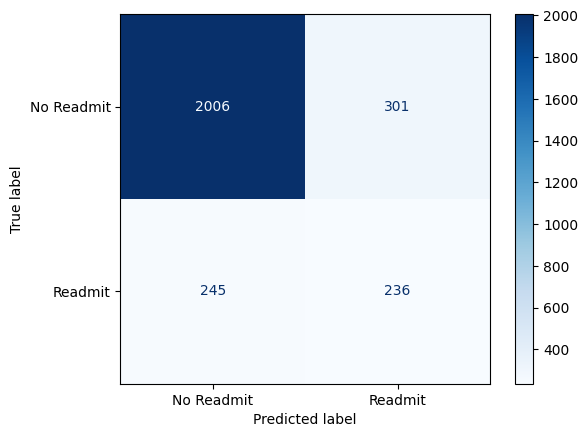


Step 3e: SVC Model Training and Evaluation Complete.


In [15]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time # To time the fitting process

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist from previous steps

# --- 1. Initialize SVM (SVC) Model ---
print("Initializing SVC model...")
print("Warning: SVC fitting with probability=True can be slow.")

# Initialize SVC
# probability=True is required for predict_proba but slows down training significantly
# class_weight='balanced' handles imbalance
# RBF kernel is default and often powerful, but most computationally expensive
svc_model = SVC(
    kernel='rbf',            # Default non-linear kernel
    probability=True,        # Enable probability estimates (SLOW!)
    class_weight='balanced', # Handle imbalance
    random_state=42,
    C=1.0,                   # Default regularization parameter (can be tuned)
    gamma='scale'            # Default kernel coefficient (can be tuned)
)

# --- 2. Train SVC Model ---
print("\nTraining SVC model (this may take several minutes)...")

start_time = time.time()
try:
    svc_model.fit(X_train_filt, y_train_int) # Use integer labels
    end_time = time.time()
    fit_duration = end_time - start_time
    print(f"\nTraining complete. Fit time: {fit_duration:.2f} seconds")

    # --- 3. Evaluate on Validation Set ---
    print("\nEvaluating SVC model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_svc = svc_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_svc = svc_model.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_svc = roc_auc_score(y_valid_int, y_valid_pred_proba_svc)
    avg_precision_svc = average_precision_score(y_valid_int, y_valid_pred_proba_svc) # AUC-PR

    print(f"\nValidation Set Metrics (SVC):")
    print(f"AUC-ROC: {roc_auc_svc:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_svc:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - SVC):")
    print(classification_report(y_valid_int, y_valid_pred_labels_svc, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - SVC):")
    cm_svc = confusion_matrix(y_valid_int, y_valid_pred_labels_svc, labels=[0, 1])
    disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['No Readmit', 'Readmit'])
    disp_svc.plot(cmap=plt.cm.Blues)
    plt.show()

    print("\nStep 3e: SVC Model Training and Evaluation Complete.")

except Exception as e:
    print(f"\nAn error occurred during the SVC training/evaluation: {e}")
    # If it's a MemoryError, the dataset might be too large for default SVC

--- Training Gradient Boosting Classifier ---

Training GBT model (may take some time)...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9028           0.0310           32.78s
         2           0.8747           0.0229           33.11s
         3           0.8416           0.0172           33.39s
         4           0.8350           0.0115           32.97s
         5           0.8237           0.0094           32.47s
         6           0.8196           0.0072           32.18s
         7           0.8197           0.0069           32.14s
         8           0.7976           0.0065           32.37s
         9           0.7950           0.0055           32.04s
        10           0.7935           0.0038           31.75s
        20           0.7407           0.0010           29.23s
        30           0.7049           0.0012           27.16s
        40           0.6767           0.0000           25.24s
        50           0.6614          -0.0

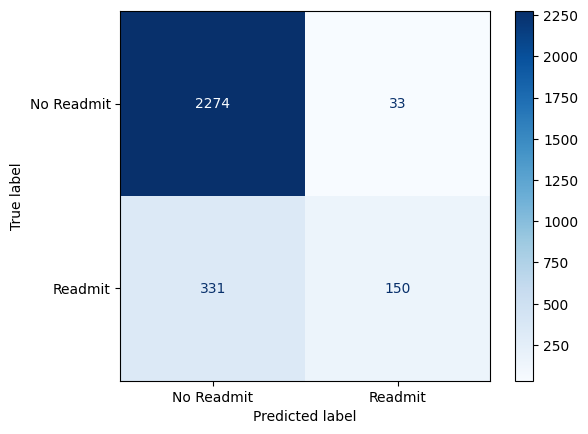


--- Gradient Boosting Complete ---


In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist

print("--- Training Gradient Boosting Classifier ---")

# Initialize GradientBoostingClassifier
# Consider adding subsample<1.0 for stochastic gradient boosting (faster, regularization)
# n_iter_no_change and tol can provide early stopping based on validation score
gbt_model = GradientBoostingClassifier(
    n_estimators=200,        # Number of boosting stages (can be tuned)
    learning_rate=0.1,       # Default learning rate (can be tuned)
    max_depth=3,             # Default tree depth (can be tuned)
    subsample=0.8,           # Use 80% of samples for fitting individual trees
    random_state=42,
    validation_fraction=0.1, # Use 10% of training data for validation score
    n_iter_no_change=20,     # Stop if validation score doesn't improve for 20 iterations
    tol=0.0001,
    verbose=1                # Show progress
)

# --- Train GBT Model ---
print("\nTraining GBT model (may take some time)...")
start_time = time.time()
try:
    gbt_model.fit(X_train_filt, y_train_int) # Use integer labels
    end_time = time.time()
    fit_duration = end_time - start_time
    print(f"\nTraining complete. Fit time: {fit_duration:.2f} seconds")
    print(f"Actual number of estimators used: {len(gbt_model.estimators_)}")


    # --- Evaluate on Validation Set ---
    print("\nEvaluating GBT model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_gbt = gbt_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_gbt = gbt_model.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_gbt = roc_auc_score(y_valid_int, y_valid_pred_proba_gbt)
    avg_precision_gbt = average_precision_score(y_valid_int, y_valid_pred_proba_gbt) # AUC-PR

    print(f"\nValidation Set Metrics (Gradient Boosting):")
    print(f"AUC-ROC: {roc_auc_gbt:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_gbt:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - Gradient Boosting):")
    print(classification_report(y_valid_int, y_valid_pred_labels_gbt, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - Gradient Boosting):")
    cm_gbt = confusion_matrix(y_valid_int, y_valid_pred_labels_gbt, labels=[0, 1])
    disp_gbt = ConfusionMatrixDisplay(confusion_matrix=cm_gbt, display_labels=['No Readmit', 'Readmit'])
    disp_gbt.plot(cmap=plt.cm.Blues)
    plt.show()

except Exception as e:
    print(f"\nAn error occurred during the Gradient Boosting training/evaluation: {e}")

print("\n--- Gradient Boosting Complete ---")

In [17]:
import pandas as pd
import numpy as np
# Ensure GradientBoostingClassifier is available if needed
# from sklearn.ensemble import GradientBoostingClassifier

# --- Generate Predictions for Submission (Gradient Boosting Model) ---

print("--- Generating Predictions for Submission (Gradient Boosting Model) ---")

try:
    # Predict probabilities on the test set using the trained gbt_model
    # Ensure the model variable name matches the one you used (gbt_model)
    test_pred_proba_gbt = gbt_model.predict_proba(X_test_filt)[:, 1]

    # Create the submission DataFrame
    submission_df_gbt_untuned = pd.DataFrame({
        'id': test_agg_df.index, # Get IDs from the index
        'readmitted_within_30days': test_pred_proba_gbt
    })

    print("\nExample Submission DataFrame:")
    print(submission_df_gbt_untuned.head())

    # Define filename and save to CSV
    submission_filename_gbt = 'gbt_untuned_submission.csv'
    submission_df_gbt_untuned.to_csv(submission_filename_gbt, index=False)

    print(f"\nSubmission file saved as: {submission_filename_gbt}")
    print("You can now submit this file to check the Gradient Boosting model's leaderboard score.")

except NameError as e:
    print(f"Error: A required variable (like gbt_model, X_test_filt, or test_agg_df) was not found.")
    print(f"Please ensure the previous steps defining these variables were run successfully. Specific error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Generating Predictions for Submission (Gradient Boosting Model) ---

Example Submission DataFrame:
                  id  readmitted_within_30days
0  16026764_21404901                  0.119086
1  18463717_24608289                  0.878158
2  16914073_28403863                  0.229072
3  17119335_28722930                  0.079688
4  10599715_20082646                  0.054511

Submission file saved as: gbt_untuned_submission.csv
You can now submit this file to check the Gradient Boosting model's leaderboard score.



--- Training AdaBoost Classifier ---

Training AdaBoost model...

Training complete. Fit time: 13.45 seconds

Evaluating AdaBoost model on validation set...

Validation Set Metrics (AdaBoost):
AUC-ROC: 0.7449
AUC-PR (Average Precision): 0.5140

Classification Report (Validation Set - AdaBoost):
                precision    recall  f1-score   support

No Readmit (0)       0.87      0.97      0.92      2307
   Readmit (1)       0.70      0.32      0.44       481

      accuracy                           0.86      2788
     macro avg       0.79      0.65      0.68      2788
  weighted avg       0.84      0.86      0.84      2788


Confusion Matrix (Validation Set - AdaBoost):


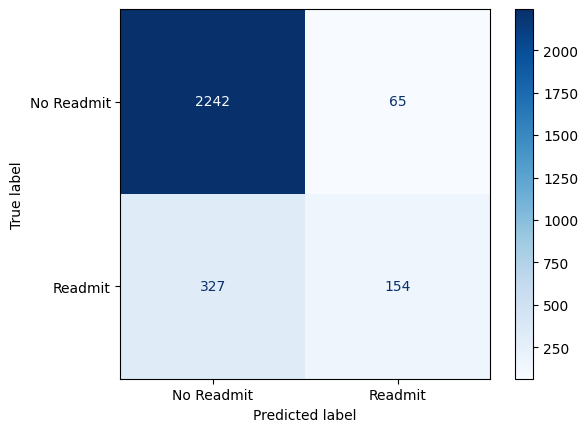


--- AdaBoost Complete ---


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
# If using DecisionTreeClassifier as base explicitly: from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist

print("\n--- Training AdaBoost Classifier ---")

# Initialize AdaBoostClassifier
# Base estimator defaults to DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(
    n_estimators=200,        # Number of weak learners (can be tuned)
    learning_rate=1.0,       # Default (can be tuned)
    random_state=42,
    # algorithm='SAMME.R' # Default, requires base estimator to support predict_proba
)

# --- Train AdaBoost Model ---
print("\nTraining AdaBoost model...")
start_time = time.time()
try:
    ada_model.fit(X_train_filt, y_train_int) # Use integer labels
    end_time = time.time()
    fit_duration = end_time - start_time
    print(f"\nTraining complete. Fit time: {fit_duration:.2f} seconds")

    # --- Evaluate on Validation Set ---
    print("\nEvaluating AdaBoost model on validation set...")

    # Predict probabilities
    y_valid_pred_proba_ada = ada_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_ada = ada_model.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_ada = roc_auc_score(y_valid_int, y_valid_pred_proba_ada)
    avg_precision_ada = average_precision_score(y_valid_int, y_valid_pred_proba_ada) # AUC-PR

    print(f"\nValidation Set Metrics (AdaBoost):")
    print(f"AUC-ROC: {roc_auc_ada:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_ada:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - AdaBoost):")
    print(classification_report(y_valid_int, y_valid_pred_labels_ada, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - AdaBoost):")
    cm_ada = confusion_matrix(y_valid_int, y_valid_pred_labels_ada, labels=[0, 1])
    disp_ada = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=['No Readmit', 'Readmit'])
    disp_ada.plot(cmap=plt.cm.Blues)
    plt.show()

except Exception as e:
    print(f"\nAn error occurred during the AdaBoost training/evaluation: {e}")

print("\n--- AdaBoost Complete ---")


--- Training K-Nearest Neighbors Classifier ---

Fitting KNN model...

Fitting complete. Fit time: 0.03 seconds

Evaluating KNN model on validation set (predict_proba may be slow)...
Prediction complete. Predict time: 1.24 seconds

Validation Set Metrics (KNN, k=21):
AUC-ROC: 0.7209
AUC-PR (Average Precision): 0.4676

Classification Report (Validation Set - KNN):
                precision    recall  f1-score   support

No Readmit (0)       0.84      1.00      0.91      2307
   Readmit (1)       0.89      0.10      0.19       481

      accuracy                           0.84      2788
     macro avg       0.87      0.55      0.55      2788
  weighted avg       0.85      0.84      0.79      2788


Confusion Matrix (Validation Set - KNN):


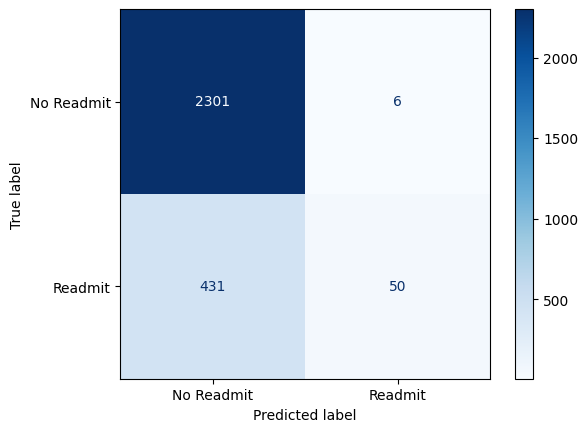


--- K-Nearest Neighbors Complete ---


In [19]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist

print("\n--- Training K-Nearest Neighbors Classifier ---")
print("Warning: KNN predict_proba can be slow on high-dimensional data.")

# Initialize KNeighborsClassifier
# Choose a value for k (n_neighbors) - common to try odd numbers like 5, 11, 21 etc.
# weights='distance' gives more influence to closer neighbors
knn_model = KNeighborsClassifier(
    n_neighbors=21,         # Number of neighbors (key hyperparameter)
    weights='distance',     # Weight points by inverse of their distance
    n_jobs=-1               # Use all available cores for neighbor search
)

# --- Train KNN Model ---
# KNN fitting is usually very fast as it just stores the data
print("\nFitting KNN model...")
start_time = time.time()
try:
    knn_model.fit(X_train_filt, y_train_int) # Use integer labels
    end_time = time.time()
    fit_duration = end_time - start_time
    print(f"\nFitting complete. Fit time: {fit_duration:.2f} seconds")

    # --- Evaluate on Validation Set ---
    # Prediction (especially predict_proba) is the slow part for KNN
    print("\nEvaluating KNN model on validation set (predict_proba may be slow)...")
    start_time = time.time()

    # Predict probabilities
    y_valid_pred_proba_knn = knn_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    # Note: predict will also be slow, but maybe faster than predict_proba
    y_valid_pred_labels_knn = knn_model.predict(X_valid_filt)

    end_time = time.time()
    predict_duration = end_time - start_time
    print(f"Prediction complete. Predict time: {predict_duration:.2f} seconds")


    # Calculate Metrics
    roc_auc_knn = roc_auc_score(y_valid_int, y_valid_pred_proba_knn)
    avg_precision_knn = average_precision_score(y_valid_int, y_valid_pred_proba_knn) # AUC-PR

    print(f"\nValidation Set Metrics (KNN, k={knn_model.n_neighbors}):")
    print(f"AUC-ROC: {roc_auc_knn:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_knn:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - KNN):")
    print(classification_report(y_valid_int, y_valid_pred_labels_knn, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - KNN):")
    cm_knn = confusion_matrix(y_valid_int, y_valid_pred_labels_knn, labels=[0, 1])
    disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['No Readmit', 'Readmit'])
    disp_knn.plot(cmap=plt.cm.Blues)
    plt.show()

except Exception as e:
    print(f"\nAn error occurred during the KNN training/evaluation: {e}")

print("\n--- K-Nearest Neighbors Complete ---")

In [20]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight

# Assume y_train_int exists (integer {0, 1} labels for training set)
print("Calculating sample weights for imbalance...")
# Using 'balanced' mode logic to compute weights per sample
train_sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_int)
print(f"Generated {len(train_sample_weights)} sample weights.")
# Display weights for first few samples of each class (optional check)
print(f"Example weight for class 0: {train_sample_weights[y_train_int == 0][0]:.2f}")
print(f"Example weight for class 1: {train_sample_weights[y_train_int == 1][0]:.2f}")

Calculating sample weights for imbalance...
Generated 8234 sample weights.
Example weight for class 0: 0.61
Example weight for class 1: 2.84



--- Training Gradient Boosting Classifier w/ Sample Weights ---

Training GBT model with sample weights...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3397           0.0351            2.01m
         2           1.3028           0.0326            2.01m
         3           1.2705           0.0272            1.99m
         4           1.2401           0.0210            1.97m
         5           1.2144           0.0164            1.97m
         6           1.1929           0.0157            1.95m
         7           1.1727           0.0155            1.92m
         8           1.1516           0.0109            1.91m
         9           1.1295           0.0092            1.90m
        10           1.1118           0.0109            1.90m
        20           0.9936           0.0050            1.88m
        30           0.9228           0.0026            1.87m
        40           0.8470          -0.0001            1.82m
        50           0.

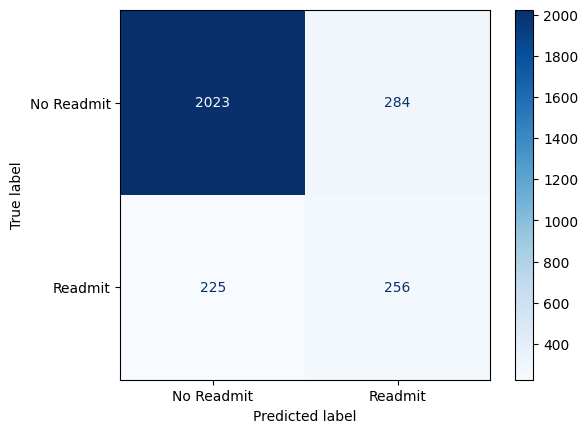


--- Gradient Boosting w/ Sample Weights Complete ---


In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist
# Assume train_sample_weights calculated above

print("\n--- Training Gradient Boosting Classifier w/ Sample Weights ---")

# Initialize GradientBoostingClassifier with early stopping params
gbt_sw_model = GradientBoostingClassifier(
    n_estimators=500,        # Increase max estimators slightly, rely on early stopping
    learning_rate=0.1,
    max_depth=5,             # Try a slightly deeper default depth
    subsample=0.8,
    random_state=42,
    validation_fraction=0.1, # Use 10% of training data (weighted) for internal validation
    n_iter_no_change=20,     # Stop if validation score doesn't improve
    tol=0.0001,
    verbose=1
)

# --- Train GBT Model w/ Sample Weights ---
print("\nTraining GBT model with sample weights...")
start_time = time.time()
try:
    # Pass sample weights to fit method
    gbt_sw_model.fit(X_train_filt, y_train_int, sample_weight=train_sample_weights)
    end_time = time.time()
    fit_duration = end_time - start_time
    print(f"\nTraining complete. Fit time: {fit_duration:.2f} seconds")
    # Check actual estimators used
    if hasattr(gbt_sw_model, 'n_estimators_'):
         print(f"Actual number of estimators used: {gbt_sw_model.n_estimators_}")
    else: # Older sklearn versions might not set n_estimators_ correctly with early stopping
         print(f"Actual number of estimators used (from array): {len(gbt_sw_model.estimators_)}")


    # --- Evaluate on Validation Set ---
    print("\nEvaluating GBT model (w/ sample weights) on validation set...")

    # Predict probabilities
    y_valid_pred_proba_gbt_sw = gbt_sw_model.predict_proba(X_valid_filt)[:, 1]

    # Predict class labels (threshold 0.5)
    y_valid_pred_labels_gbt_sw = gbt_sw_model.predict(X_valid_filt)

    # Calculate Metrics
    roc_auc_gbt_sw = roc_auc_score(y_valid_int, y_valid_pred_proba_gbt_sw)
    avg_precision_gbt_sw = average_precision_score(y_valid_int, y_valid_pred_proba_gbt_sw) # AUC-PR

    print(f"\nValidation Set Metrics (Gradient Boosting w/ Sample Weights):")
    print(f"AUC-ROC: {roc_auc_gbt_sw:.4f}")
    print(f"AUC-PR (Average Precision): {avg_precision_gbt_sw:.4f}")


    # Classification Report
    print("\nClassification Report (Validation Set - GBT w/ Sample Weights):")
    print(classification_report(y_valid_int, y_valid_pred_labels_gbt_sw, target_names=['No Readmit (0)', 'Readmit (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix (Validation Set - GBT w/ Sample Weights):")
    cm_gbt_sw = confusion_matrix(y_valid_int, y_valid_pred_labels_gbt_sw, labels=[0, 1])
    disp_gbt_sw = ConfusionMatrixDisplay(confusion_matrix=cm_gbt_sw, display_labels=['No Readmit', 'Readmit'])
    disp_gbt_sw.plot(cmap=plt.cm.Blues)
    plt.show()

except Exception as e:
    print(f"\nAn error occurred during the Gradient Boosting training/evaluation: {e}")

print("\n--- Gradient Boosting w/ Sample Weights Complete ---")

In [22]:
import pandas as pd
import numpy as np
# Ensure GradientBoostingClassifier is available if needed
# from sklearn.ensemble import GradientBoostingClassifier

# Assume gbt_sw_model is the trained Gradient Boosting model w/ Sample Weights
# Assume X_test_filt is the scaled and filtered test data
# Assume test_agg_df holds the aggregated test IDs in its index

# --- Generate Predictions for Submission (Gradient Boosting w/ Sample Weights Model) ---

print("--- Generating Predictions for Submission (Gradient Boosting w/ Sample Weights Model) ---")

try:
    # Predict probabilities on the test set using the gbt_sw_model
    test_pred_proba_gbt_sw = gbt_sw_model.predict_proba(X_test_filt)[:, 1]

    # Create the submission DataFrame
    submission_df_gbt_sw = pd.DataFrame({
        'id': test_agg_df.index, # Get IDs from the index
        'readmitted_within_30days': test_pred_proba_gbt_sw
    })

    print("\nExample Submission DataFrame:")
    print(submission_df_gbt_sw.head())

    # Define filename and save to CSV
    submission_filename_gbt_sw = 'gbt_sample_weighted_submission.csv'
    submission_df_gbt_sw.to_csv(submission_filename_gbt_sw, index=False)

    print(f"\nSubmission file saved as: {submission_filename_gbt_sw}")
    print("You can now submit this file to check the Gradient Boosting (w/ sample weights) model's leaderboard score.")

except NameError as e:
    print(f"Error: A required variable (like gbt_sw_model, X_test_filt, or test_agg_df) was not found.")
    print(f"Please ensure the previous steps defining these variables were run successfully. Specific error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Generating Predictions for Submission (Gradient Boosting w/ Sample Weights Model) ---

Example Submission DataFrame:
                  id  readmitted_within_30days
0  16026764_21404901                  0.416239
1  18463717_24608289                  0.959813
2  16914073_28403863                  0.661983
3  17119335_28722930                  0.269899
4  10599715_20082646                  0.115466

Submission file saved as: gbt_sample_weighted_submission.csv
You can now submit this file to check the Gradient Boosting (w/ sample weights) model's leaderboard score.


In [23]:
# Ensure necessary libraries are imported
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score # Optimize for AUC-ROC
import numpy as np
import pandas as pd
import time # To time the final fit maybe

# Assume X_train_filt, y_train_int, X_valid_filt, y_valid_int exist
# Assume X_test_filt, test_agg_df also exist for the final prediction part

# --- Tune Gradient Boosting (No Sample Weights) using Optuna ---

print("--- Starting Gradient Boosting Tuning with Optuna (Optimizing AUC-ROC) ---")
print("Note: Tuning GBT can take some time.")

def objective_gbt(trial):
    # Define hyperparameters to search
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1500, step=100) # Max estimators, early stopping helps
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    subsample = trial.suggest_float('subsample', 0.6, 1.0, step=0.05) # Stochastic gradient boosting
    max_features_type = trial.suggest_categorical('max_features_type', ['sqrt', 'log2', 'float'])
    if max_features_type == 'float':
        max_features = trial.suggest_float('max_features_float', 0.1, 1.0)
    else:
        max_features = max_features_type

    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'subsample': subsample,
        'max_features': max_features,
        'validation_fraction': 0.1, # Use 10% of training data for internal early stopping validation
        'n_iter_no_change': 30,     # Stop if score doesn't improve for 30 iterations (adjust if needed)
        'tol': 0.0001,
        'random_state': 42,
        'verbose': 0 # Suppress verbose output during tuning trials
    }

    model = GradientBoostingClassifier(**params)

    try:
        model.fit(X_train_filt, y_train_int) # NO sample_weight here
    except Exception as e:
         print(f"Error during GBT fit in trial {trial.number}: {e}")
         return 0.0 # Return low score if fit fails

    # Use actual number of estimators found by early stopping for storing potentially
    actual_estimators = len(model.estimators_)
    trial.set_user_attr("actual_estimators", actual_estimators)

    preds_proba = model.predict_proba(X_valid_filt)[:, 1]
    auc_roc = roc_auc_score(y_valid_int, preds_proba) # Calculate AUC-ROC
    return auc_roc # Return AUC-ROC score for maximization

# Create and run the Optuna study
study_gbt = optuna.create_study(direction='maximize') # Maximize AUC-ROC
N_TRIALS_GBT = 50 # Adjust as needed (e.g., 50-100)
study_gbt.optimize(objective_gbt, n_trials=N_TRIALS_GBT)

print("\n--- Gradient Boosting Tuning Complete ---")
print(f"Best Validation AUC-ROC: {study_gbt.best_value:.4f}")
print("Best hyperparameters (including inferred n_estimators):")
best_params_gbt = study_gbt.best_params
# Clean up helper keys if they exist
best_params_gbt.pop('max_features_type', None)
best_params_gbt.pop('max_features_float', None)
# Add the actual number of estimators used in the best trial
best_params_gbt['n_estimators'] = study_gbt.best_trial.user_attrs.get('actual_estimators', best_params_gbt.get('n_estimators')) # Use actual if available
print(best_params_gbt)


[I 2025-04-29 14:59:22,117] A new study created in memory with name: no-name-e24b94d4-0a46-4f0f-86e0-f511bd221689


--- Starting Gradient Boosting Tuning with Optuna (Optimizing AUC-ROC) ---
Note: Tuning GBT can take some time.


[I 2025-04-29 14:59:23,194] Trial 0 finished with value: 0.7681845094068761 and parameters: {'learning_rate': 0.015432945440804828, 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 37, 'subsample': 0.95, 'max_features_type': 'log2'}. Best is trial 0 with value: 0.7681845094068761.
[I 2025-04-29 14:59:32,860] Trial 1 finished with value: 0.7826023482720492 and parameters: {'learning_rate': 0.02906315577115287, 'n_estimators': 900, 'max_depth': 7, 'min_samples_split': 48, 'min_samples_leaf': 47, 'subsample': 1.0, 'max_features_type': 'sqrt'}. Best is trial 1 with value: 0.7826023482720492.
[I 2025-04-29 14:59:34,881] Trial 2 finished with value: 0.7745071269128486 and parameters: {'learning_rate': 0.09084190586178936, 'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 26, 'min_samples_leaf': 29, 'subsample': 0.6, 'max_features_type': 'log2'}. Best is trial 1 with value: 0.7826023482720492.
[I 2025-04-29 14:59:37,618] Trial 3 finished with value: 0.


--- Gradient Boosting Tuning Complete ---
Best Validation AUC-ROC: 0.7916
Best hyperparameters (including inferred n_estimators):
{'learning_rate': 0.010390522792751843, 'n_estimators': 692, 'max_depth': 8, 'min_samples_split': 30, 'min_samples_leaf': 11, 'subsample': 0.75}


In [25]:
# --- Imports and Imputation Only ---
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score # Use AUC-ROC
import matplotlib.pyplot as plt
import time
import lightgbm as lgb

# Assume X_train, y_train_int, X_valid_int, X_test, test_agg_df are available
# Also assumes 'feature_names' list exists if you want named columns back
print("Running Imports and Imputation...")
try:
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_valid_imputed = imputer.transform(X_valid)
    X_test_imputed = imputer.transform(X_test)

    # Optional: Convert back to DataFrame
    try:
         X_train_imputed_df = pd.DataFrame(X_train_imputed, index=X_train.index, columns=feature_names)
         X_valid_imputed_df = pd.DataFrame(X_valid_imputed, index=X_valid.index, columns=feature_names)
         X_test_imputed_df = pd.DataFrame(X_test_imputed, index=X_test.index, columns=feature_names)
         print("Imputation and DataFrame conversion successful.")
    except NameError:
         print("Warning: 'feature_names' not found, using numpy arrays.")
         X_train_imputed_df = X_train_imputed
         X_valid_imputed_df = X_valid_imputed
         X_test_imputed_df = X_test_imputed
         print("Imputation successful (using numpy arrays).")

except Exception as e:
    print(f"\nAn error occurred during import or imputation: {e}")

print("--- Imports and Imputation Check Complete ---")

Running Imports and Imputation...
Imputation and DataFrame conversion successful.
--- Imports and Imputation Check Complete ---


In [ ]:
# --- Imports and Imputation Only ---
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score # Use AUC-ROC
import matplotlib.pyplot as plt
import time
import lightgbm as lgb

# Assume X_train, y_train_int, X_valid_int, X_test, test_agg_df are available
# Also assumes 'feature_names' list exists if you want named columns back
print("Running Imports and Imputation...")
try:
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_valid_imputed = imputer.transform(X_valid)
    X_test_imputed = imputer.transform(X_test)

    # Optional: Convert back to DataFrame
    try:
         X_train_imputed_df = pd.DataFrame(X_train_imputed, index=X_train.index, columns=feature_names)
         X_valid_imputed_df = pd.DataFrame(X_valid_imputed, index=X_valid.index, columns=feature_names)
         X_test_imputed_df = pd.DataFrame(X_test_imputed, index=X_test.index, columns=feature_names)
         print("Imputation and DataFrame conversion successful.")
    except NameError:
         print("Warning: 'feature_names' not found, using numpy arrays.")
         X_train_imputed_df = X_train_imputed
         X_valid_imputed_df = X_valid_imputed
         X_test_imputed_df = X_test_imputed
         print("Imputation successful (using numpy arrays).")

except Exception as e:
    print(f"\nAn error occurred during import or imputation: {e}")

print("--- Imports and Imputation Check Complete ---")

In [26]:
# --- Run GBT Section Only ---
# Assumes variables from the previous cell (imputed data) are available
print("\n--- Running GBT (Before Scaling/Filtering) ---")
try:
    gbt_before = GradientBoostingClassifier(
        n_estimators=118, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42, verbose=0
    )
    start_time = time.time()
    gbt_before.fit(X_train_imputed_df, y_train_int)
    fit_duration = time.time() - start_time
    print(f"GBT Fit Time: {fit_duration:.2f}s")

    y_valid_pred_proba_gbt_before = gbt_before.predict_proba(X_valid_imputed_df)[:, 1]
    roc_auc_gbt_before = roc_auc_score(y_valid_int, y_valid_pred_proba_gbt_before)
    print(f"GBT Validation AUC-ROC (Before Proc.): {roc_auc_gbt_before:.4f}")

    test_pred_proba_gbt_before = gbt_before.predict_proba(X_test_imputed_df)[:, 1]
    submission_df_gbt_before = pd.DataFrame({'id': test_agg_df.index, 'readmitted_within_30days': test_pred_proba_gbt_before})
    submission_filename_gbt_before = 'gbt_before_processing_submission.csv'
    submission_df_gbt_before.to_csv(submission_filename_gbt_before, index=False)
    print(f"Submission file saved as: {submission_filename_gbt_before}")
except Exception as e:
    print(f"\nAn error occurred during the GBT section: {e}")
print("\n--- GBT Section Complete ---")


--- Running GBT (Before Scaling/Filtering) ---
GBT Fit Time: 14.70s
GBT Validation AUC-ROC (Before Proc.): 0.7778
Submission file saved as: gbt_before_processing_submission.csv

--- GBT Section Complete ---


In [27]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score # Using AUC-ROC as requested
import matplotlib.pyplot as plt
import time
import re # Import regular expression library
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')


# Assume X_train, y_train_int, X_valid_int, X_test, test_agg_df are available
# Also assumes 'feature_names' list exists (original 855 aggregated feature names)

# --- 1. Impute Missing Values (using Median) ---
print("Applying Median Imputation...")
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)
X_test_imputed = imputer.transform(X_test)
print("Imputation complete.")

# Convert back to DataFrame using original feature names
try:
    X_train_imputed_df = pd.DataFrame(X_train_imputed, index=X_train.index, columns=feature_names)
    X_valid_imputed_df = pd.DataFrame(X_valid_imputed, index=X_valid.index, columns=feature_names)
    X_test_imputed_df = pd.DataFrame(X_test_imputed, index=X_test.index, columns=feature_names)
    print("DataFrame conversion successful.")
except NameError:
    print("Error: 'feature_names' variable not found. Cannot proceed without column names for renaming.")
    raise # Stop if feature names aren't available

# --- 2. Clean Feature Names (Rename Columns) ---
print("\nCleaning feature names for LightGBM compatibility...")

# Function to clean names: replace non-alphanumeric chars (excluding underscore) with underscore
def clean_col_names(col_name):
    return re.sub(r'[^A-Za-z0-9_]+', '_', str(col_name))

original_columns = X_train_imputed_df.columns.tolist()
cleaned_columns = [clean_col_names(col) for col in original_columns]

# Rename columns in all dataframes
X_train_imputed_df.columns = cleaned_columns
X_valid_imputed_df.columns = cleaned_columns
X_test_imputed_df.columns = cleaned_columns

print(f"Example cleaned feature name: {cleaned_columns[0]}")
print("Column renaming complete.")

# --- 3. Run LGBM (Untuned 'fixed' config) ---
print("\n--- Running LGBM (Before Scaling/Filtering, Cleaned Names) ---")
try:
    scale_pos_weight_value = np.sum(y_train_int == 0) / np.sum(y_train_int == 1)
    lgbm_before = lgb.LGBMClassifier(
        objective='binary', metric='aucpr', scale_pos_weight=scale_pos_weight_value,
        random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=31, verbose=-1
    )
    start_time = time.time()
    # Fit using dataframe with cleaned names
    lgbm_before.fit(X_train_imputed_df, y_train_int)
    fit_duration = time.time() - start_time
    print(f"LGBM Fit Time: {fit_duration:.2f}s")

    # Evaluate
    y_valid_pred_proba_lgbm_before = lgbm_before.predict_proba(X_valid_imputed_df)[:, 1]
    roc_auc_lgbm_before = roc_auc_score(y_valid_int, y_valid_pred_proba_lgbm_before)
    print(f"LGBM Validation AUC-ROC (Before Proc.): {roc_auc_lgbm_before:.4f}")

    # Generate Submission
    test_pred_proba_lgbm_before = lgbm_before.predict_proba(X_test_imputed_df)[:, 1]
    submission_df_lgbm_before = pd.DataFrame({'id': test_agg_df.index, 'readmitted_within_30days': test_pred_proba_lgbm_before})
    submission_filename_lgbm_before = 'lgbm_before_processing_submission.csv'
    submission_df_lgbm_before.to_csv(submission_filename_lgbm_before, index=False)
    print(f"Submission file saved as: {submission_filename_lgbm_before}")

except Exception as e:
    print(f"\nAn error occurred during the LGBM section: {e}")
print("\n--- LGBM Section Complete ---")


# --- 4. Run GBT (Untuned config w/ Early Stopping) ---
print("\n--- Running GBT (Before Scaling/Filtering, Cleaned Names) ---")
# Note: GBT is less sensitive to names, but using cleaned names for consistency
try:
    gbt_before = GradientBoostingClassifier(
        n_estimators=118, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42, verbose=0
    )
    start_time = time.time()
    # Fit using dataframe with cleaned names
    gbt_before.fit(X_train_imputed_df, y_train_int) # No sample weights
    fit_duration = time.time() - start_time
    print(f"GBT Fit Time: {fit_duration:.2f}s")

    # Evaluate
    y_valid_pred_proba_gbt_before = gbt_before.predict_proba(X_valid_imputed_df)[:, 1]
    roc_auc_gbt_before = roc_auc_score(y_valid_int, y_valid_pred_proba_gbt_before)
    print(f"GBT Validation AUC-ROC (Before Proc.): {roc_auc_gbt_before:.4f}") # Re-print score for clarity

    # Generate Submission (Optional: Overwrite previous GBT file or use new name)
    test_pred_proba_gbt_before = gbt_before.predict_proba(X_test_imputed_df)[:, 1]
    submission_df_gbt_before = pd.DataFrame({'id': test_agg_df.index, 'readmitted_within_30days': test_pred_proba_gbt_before})
    submission_filename_gbt_before = 'gbt_before_processing_submission.csv' # Same name as before
    submission_df_gbt_before.to_csv(submission_filename_gbt_before, index=False)
    print(f"Submission file saved as: {submission_filename_gbt_before}")

except Exception as e:
    print(f"\nAn error occurred during the GBT section: {e}")
print("\n--- GBT Section Complete ---")


# --- 5. Run RF (Untuned config) ---
print("\n--- Running RF (Before Scaling/Filtering, Cleaned Names) ---")
# Note: RF is less sensitive to names, but using cleaned names for consistency
try:
    rf_before = RandomForestClassifier(
        n_estimators=200, class_weight='balanced_subsample', random_state=42, n_jobs=-1, verbose=0
    )
    start_time = time.time()
     # Fit using dataframe with cleaned names
    rf_before.fit(X_train_imputed_df, y_train_int)
    fit_duration = time.time() - start_time
    print(f"RF Fit Time: {fit_duration:.2f}s")

    # Evaluate
    y_valid_pred_proba_rf_before = rf_before.predict_proba(X_valid_imputed_df)[:, 1]
    roc_auc_rf_before = roc_auc_score(y_valid_int, y_valid_pred_proba_rf_before)
    print(f"RF Validation AUC-ROC (Before Proc.): {roc_auc_rf_before:.4f}")

    # Generate Submission
    test_pred_proba_rf_before = rf_before.predict_proba(X_test_imputed_df)[:, 1]
    submission_df_rf_before = pd.DataFrame({'id': test_agg_df.index, 'readmitted_within_30days': test_pred_proba_rf_before})
    submission_filename_rf_before = 'rf_before_processing_submission.csv' # Same name as before
    submission_df_rf_before.to_csv(submission_filename_rf_before, index=False)
    print(f"Submission file saved as: {submission_filename_rf_before}")

except Exception as e:
    print(f"\nAn error occurred during the RF section: {e}")
print("\n--- RF Section Complete ---")


print("\n--- Comparison Complete (Using Cleaned Feature Names) ---")

Applying Median Imputation...
Imputation complete.
DataFrame conversion successful.

Cleaning feature names for LightGBM compatibility...
Example cleaned feature name: age_mean
Column renaming complete.

--- Running LGBM (Before Scaling/Filtering, Cleaned Names) ---
LGBM Fit Time: 1.44s
LGBM Validation AUC-ROC (Before Proc.): 0.7702
Submission file saved as: lgbm_before_processing_submission.csv

--- LGBM Section Complete ---

--- Running GBT (Before Scaling/Filtering, Cleaned Names) ---
GBT Fit Time: 14.43s
GBT Validation AUC-ROC (Before Proc.): 0.7778
Submission file saved as: gbt_before_processing_submission.csv

--- GBT Section Complete ---

--- Running RF (Before Scaling/Filtering, Cleaned Names) ---
RF Fit Time: 2.92s
RF Validation AUC-ROC (Before Proc.): 0.7828
Submission file saved as: rf_before_processing_submission.csv

--- RF Section Complete ---

--- Comparison Complete (Using Cleaned Feature Names) ---


Generating plot using score variables...


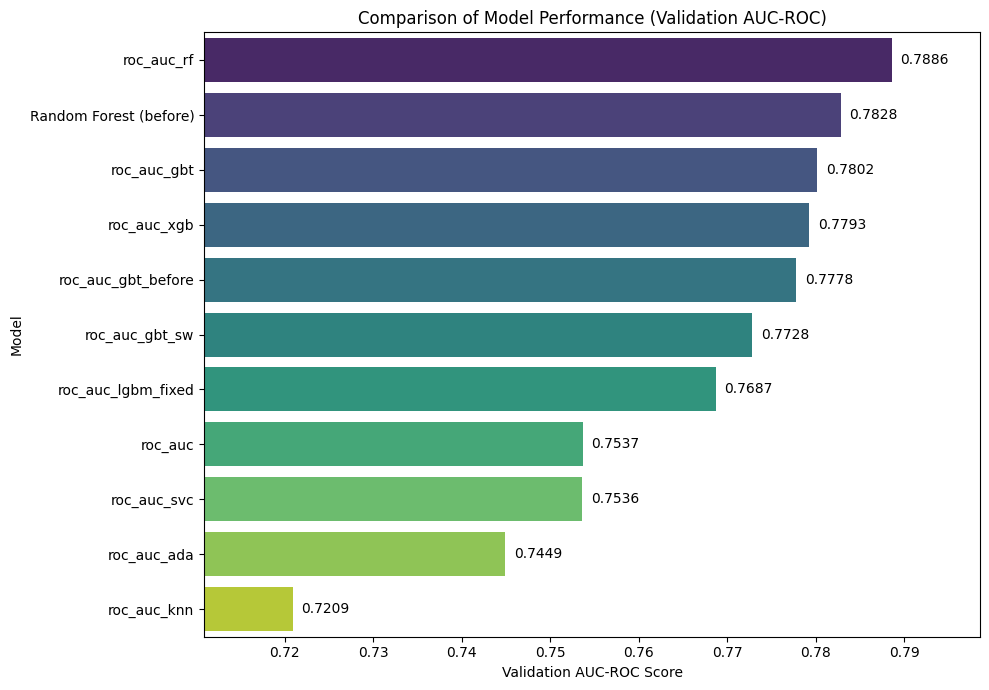

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Create Dictionary Using Variable Names ---
# This dictionary maps model names to the VARIABLES holding their scores
model_scores_vars = {

        'roc_auc_gbt_before': roc_auc_gbt_before,
        'Random Forest (before)': roc_auc_rf_before,
        'roc_auc_gbt_sw':roc_auc_gbt_sw,
        'roc_auc_knn':roc_auc_knn,
        'roc_auc_ada':roc_auc_ada,
        'roc_auc_gbt':roc_auc_gbt,
        'roc_auc_svc':roc_auc_svc,
        'roc_auc_rf':roc_auc_rf,
        'roc_auc_xgb':roc_auc_xgb,
        'roc_auc_lgbm_fixed':roc_auc_lgbm_fixed,
        'roc_auc':roc_auc

    }

# Convert to DataFrame for easier plotting
scores_df_vars = pd.DataFrame(list(model_scores_vars.items()), columns=['Model', 'Validation AUC-ROC'])

    # Sort by score
scores_df_vars = scores_df_vars.sort_values(by='Validation AUC-ROC', ascending=False)

    # --- Create the Bar Plot ---
print("Generating plot using score variables...")
plt.figure(figsize=(10, 7))
barplot = sns.barplot(x='Validation AUC-ROC', y='Model', data=scores_df_vars, palette='viridis', orient='h')

    # Add score labels to the bars (reading from the DataFrame column)
for index, value in enumerate(scores_df_vars['Validation AUC-ROC']):
        plt.text(value + 0.001, index, f'{value:.4f}', va='center') # Adjust position slightly

plt.xlabel('Validation AUC-ROC Score')
plt.ylabel('Model')
plt.title('Comparison of Model Performance (Validation AUC-ROC)')
plt.xlim(min(scores_df_vars['Validation AUC-ROC']) - 0.01, max(scores_df_vars['Validation AUC-ROC']) + 0.01) # Adjust limits
plt.tight_layout()
plt.show()
    
